In [1]:
from size_based_ecosystem import *
from scipy import stats

In [2]:
depth = 20 #Previously 5 has worked well.
layers = 100 #5 works well.
log_size_range = 12 # 9.5 #8 did NOT work well.
size_classes = 5
t_end = 1/10*1/365 #We're counting in days
lam = 1
time_step = 1/500000 #1/500000 #One minute #0.00001
res_max = 10
simulate = True
verbose = False
daily_cycle = 365*2*np.pi
mass_vector = np.array([1, 20, 400, 8000, 16000]) #np.array([1, 30, 300, 400, 800, 16000])


In [54]:
obj = spectral_method(depth, layers-1) #This is the old off-by-one error... Now we have added another fucked up error!
logn = stats.lognorm.pdf(obj.x, 1, 0)
#print(logn, "Logn")

res_start = 0.01*logn


water_start = water_column(obj, res_start, layers = layers, resource_max = res_max, time_step = time_step, replacement = lam, advection = 0.1, diffusion = 0)

params = ecosystem_parameters(mass_vector, obj)
og_layered_attack = np.copy(params.layered_attack)
eco = ecosystem_optimization(mass_vector, layers, params, obj, water_start, loss = 'constr')
eco.population_setter(np.array([1, 1, 1, 1, 0.1]) )#, 1, 1, 1, 0.1]))
eco.water.res_counts = 1-obj.x/depth

t = 0.498*1/365
eco.parameters.layered_attack_setter(1/2*(1.00001+np.cos(t*daily_cycle))*og_layered_attack) 


eco.strategy_setter(np.sqrt(eco.strategy_matrix.flatten())) #This is for the L2 version... Quantum fish ahoy

In [55]:
graph_builder(eco)

array([[0.00000000e+00, 1.66219859e+00, 8.26593770e+02, 7.14979901e+02,
        3.15114170e+01],
       [0.00000000e+00, 0.00000000e+00, 5.60957102e+01, 9.82124605e+03,
        1.47894927e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.66506079e+02,
        3.42928350e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [56]:
seq_nash = sequential_nash(eco, verbose = True)
eco.strategy_setter(seq_nash)
print(graph_builder(eco), "New graph")

Error:  0.8547027718891946
Error:  0.005273640339995445
Error:  0.01018096060051403
Error:  0.0026136286704379064
Error:  0.03090063508195152
Error:  0.024340037120599622
Error:  0.022529097968346692
Error:  0.017146697156402768
Error:  0.006760127058273349
Error:  0.0
[[0.00000000e+00 2.03001023e-05 1.64526945e-02 2.16076622e-05
  2.10381474e-06]
 [0.00000000e+00 0.00000000e+00 1.12550011e-03 2.38185879e-04
  1.01802435e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.08516884e-05
  1.18513381e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]] New graph


In [46]:
def seq_test(eco, verbose = False):
    x_temp = np.copy(eco.strategy_matrix.flatten())  # np.zeros(size_classes*layers)
    x_temp2 = np.copy(eco.strategy_matrix.flatten())
    error = 1
    A, one, bounds = constraint_builder(eco.spectral.M, eco.mass_vector.shape[0])
    constr1 = ({'type': 'eq', 'fun': lambda x: np.dot(A[0, 0:eco.layers], x**2) - 1}) #Now we do it L2-style!
    bounds1 = optm.Bounds(np.array([0] * eco.layers), np.array([np.inf] * eco.layers))
    ibr_mode = True
    newton_step = 0.1
    cutoff = 5
    iterations = 0
    while error > 10 ** (-8) and iterations < 40:
        for k in range(eco.mass_vector.shape[0]):
            x_temp2[k * eco.layers:(k + 1) * eco.layers] = optm.minimize(
                lambda x: -eco.one_actor_growth(eco.strategy_replacer(x, k, x_temp), k),
                x0=x_temp[eco.layers * k:eco.layers * (k + 1)], method='SLSQP', constraints=constr1, bounds=bounds1).x
        if verbose is True:
            print("Error: ", np.max(np.abs(x_temp - x_temp2)), iterations)
        error = np.max(np.abs(x_temp - x_temp2))
        if error > cutoff:
            ibr_mode = False
        elif error < cutoff:
            ibr_mode = True
        if ibr_mode is True:
            print("WHAT!???!!")
            x_temp = np.copy(x_temp2)
            plt.figure()
            plt.plot(eco.spectral.x, x_temp[eco.layers:2*eco.layers])
            plt.show()
        elif ibr_mode is False:
            print("Newtoning ", error)
            x_temp = x_temp + newton_step*x_temp2 #Not sure if this is a good idea...
            normalization_constants = np.dot(A, x_temp**2)
            for i in range(eco.mass_vector[0]):
                x_temp[i*eco.layers:(i+1)*eco.layers] = x_temp[i*eco.layers:(i+1)*eco.layers]/normalization_constants[i]
        iterations += 1
        print(iterations)
    if iterations >= 40:
        constr = ({'type': 'eq', 'fun': lambda x: np.dot(A, x) - 1})
        opt_obj = optm.minimize(lambda x: loss_func(eco.loss_function(x), size_classes= eco.mass_vector.shape[0], layers = eco.layers, spec = eco.spectral), x0 = eco.strategy_matrix.flatten(), method = 'SLSQP',  constraints = constr, bounds = bounds)

        x_temp = opt_obj.x

    return x_temp

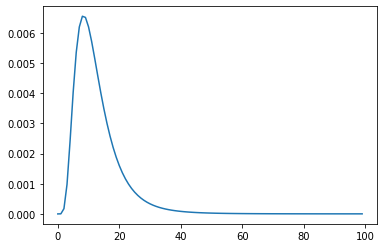

In [53]:
seq_nash = sequential_nash(eco, verbose = True)

Error:  17.762289437348247
Newtoning  17.762289437348247
Error:  16.404202194034806
Newtoning  16.404202194034806
Error:  15.151364855813494
Newtoning  15.151364855813494
Error:  14.088990144978176
Newtoning  14.088990144978176
Error:  12.793133504211927
Newtoning  12.793133504211927
Error:  11.287546332134369
Newtoning  11.287546332134369
Error:  9.62313482694156
Newtoning  9.62313482694156
Error:  7.828043579404831
Newtoning  7.828043579404831
Error:  5.925196895390711
Newtoning  5.925196895390711
Error:  4.1420635806171155
Error:  22.092904551006665
Newtoning  22.092904551006665
Error:  22.09290455100667
Newtoning  22.09290455100667
Error:  22.09290455100667
Newtoning  22.09290455100667


KeyboardInterrupt: 

In [97]:
t = 0.5*1/365
eco.parameters.layered_attack_setter(1/2*(1.00001+np.cos(t*daily_cycle))*og_layered_attack) 

In [98]:
for i in range(1,5):
    plt.plot(obj.x, new_deal[i * layers:(i + 1) * layers]**2, label = i)
plt.legend(loc = 'upper right')
plt.show()

Newtoning  5.51706916355006


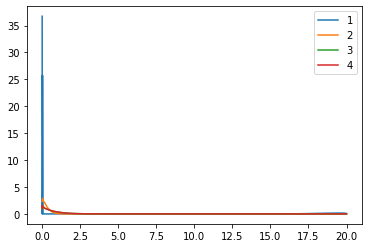

In [103]:
    plt.figure()
    for i in range(1,5):
        plt.plot(obj.x, new_deal[i * layers:(i + 1) * layers]**2, label = i)
    plt.legend(loc = 'upper right')
    plt.show()


In [60]:
A, one, bounds = constraint_builder(eco.spectral.M, eco.mass_vector.shape[0])
constr1 = ({'type': 'eq', 'fun': lambda x: np.dot(A[0, 0:eco.layers], x**2) - 1})
bounds1 = optm.Bounds(np.array([0] * eco.layers), np.array([np.inf] * eco.layers))
x_temp = np.copy(eco.strategy_matrix.flatten())

In [61]:
np.dot(eco.strategy_matrix[1], np.dot(obj.M, eco.strategy_matrix[1]))

1.0074445044837523

In [35]:
t_end = 1/2*1/365 #We're counting in days

if simulate is True:
    time_span = np.linspace(0, t_end, int(t_end/time_step))

    for t in time_span:
        eco.population_setter(eco.total_growth()*time_step + eco.populations)
#        print(eco.water.res_counts, "Before eating")

        eco.consume_resources(time_step)
 #       print(eco.water.res_counts, "After eating")
        eco.water.update_resources()
#        opt_obj = optm.minimize(
#            lambda x: loss_func(eco.loss_function(x), size_classes=size_classes, layers=layers, spec=obj),
#            x0=eco.strategy_matrix.flatten(), method='SLSQP', constraints=constr, bounds=bounds)
        eco.parameters.layered_attack_setter(1/2*(1.00001+np.cos(t*daily_cycle))*og_layered_attack) 
        x_res = sequential_nash(eco, verbose = verbose)
        eco.strategy_setter(x_res)
        #print(eco.populations, min(eco.water.res_counts), max(eco.water.res_counts), eco.total_growth(x_res))

        print(t)

    plt.figure()
    for i in range(size_classes):
        plt.plot(obj.x, x_res[i * layers:(i + 1) * layers])
    plt.plot(obj.x, eco.water.res_counts)
    plt.show()
    print(eco.populations, eco.total_growth(x_res))
    print(graph_builder(eco))
    print(eco.water.res_counts)
    print(np.dot(eco.water.res_counts, np.dot(eco.spectral.M, eco.strategy_matrix[0])))

0.0 0.0
0.0
4.0537847133025786e-08 4.0537847133025786e-08
2.005655949778375e-06
4.081214556012714e-08 4.081214556012714e-08
4.01131189955675e-06
4.100600097809463e-08 4.100600097809463e-08
6.016967849335125e-06
4.1199698900738424e-08 4.1199698900738424e-08
8.0226237991135e-06
4.1393399888355844e-08 4.1393399888355844e-08
1.0028279748891874e-05
4.158710422722144e-08 4.158710422722144e-08
Newtoning  5.085775980551392
Newtoning  5.085775980551392
Newtoning  5.0842447190316316
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368
Newtoning  5.085929106703368


Newtoning  255.4804672094797
Newtoning  275.49470975756213
Newtoning  271.26805481401226
Newtoning  244.13063826214693
2.40678713973405e-05
4.2755252648185884e-08 4.2755252648185884e-08
Newtoning  278.04671699714777
Newtoning  251.2751890495612
Newtoning  276.7031902584805
Newtoning  268.1298661089778
Newtoning  276.5758333641002
Newtoning  283.31984965494223
Newtoning  249.75535708269354
Newtoning  288.0397291704404
Newtoning  284.9027781973391
Newtoning  288.725405884355
Newtoning  283.03998853450474
Newtoning  260.2957597709025
Newtoning  280.7904220965529
Newtoning  272.56163313595584
Newtoning  291.7308616555742
Newtoning  244.77914185281216
Newtoning  295.28766250395233
Newtoning  246.25576639016538
Newtoning  294.0953508192339
Newtoning  306.46458435716914
Newtoning  253.14485455905498
Newtoning  284.7089770246199
Newtoning  297.53844416661593
Newtoning  287.2025227988102
Newtoning  321.96849192473275
Newtoning  297.49444615637736
Newtoning  291.2934180833314
Newtoning  327.6771

Newtoning  647.142419213948
Newtoning  571.4870661310651
Newtoning  652.0704390773029
Newtoning  654.9296127608375
Newtoning  654.9758786100771
Newtoning  651.4462498134147
Newtoning  586.1449822822493
Newtoning  662.1971730701542
Newtoning  658.8358672583734
Newtoning  662.5939286493626
Newtoning  653.5923108608188
Newtoning  654.2663797560485
Newtoning  650.8433784937895
Newtoning  646.7861559192073
Newtoning  660.2178806540473
Newtoning  658.9156203519323
Newtoning  660.0217198027533
Newtoning  669.7951257379332
Newtoning  665.2119606679076
3.810746304578912e-05
4.377697711693375e-08 4.377697711693375e-08
Newtoning  669.8342440137494
Newtoning  665.9880729169843
Newtoning  649.5569171218402
Newtoning  665.149397195496
Newtoning  659.586890126467
Newtoning  656.4856212223929
Newtoning  656.420275679622
Newtoning  673.9271979064313
Newtoning  668.2408192398436
Newtoning  667.4705269560011
Newtoning  662.9435745099559
Newtoning  677.287882582308
Newtoning  659.9158181945198
Newtoning  

Newtoning  1092.545422840106
Newtoning  1092.5452111687225
Newtoning  1092.3712942716327
Newtoning  1092.5566923753927
Newtoning  1092.5598206622712
Newtoning  1092.422884322977
Newtoning  1092.5778735050962
Newtoning  1092.5778269596817
Newtoning  1092.573206565952
Newtoning  1092.5779353480157
Newtoning  1092.578479016748
Newtoning  1092.5752270803814
Newtoning  1092.5786820673602
Newtoning  1091.165285016387
Newtoning  1092.7110070702888
Newtoning  1092.7203175888703
Newtoning  1092.721099081805
Newtoning  1092.7211689932417
Newtoning  1092.7204591550365
Newtoning  1092.71563935538
Newtoning  1092.7204831198328
Newtoning  1083.681334371337
Newtoning  1093.6256489588627
Newtoning  1093.6257582694832
Newtoning  1093.625167325491
Newtoning  1093.6204815402127
Newtoning  1093.625148450027
Newtoning  1093.6267450049484
Newtoning  1093.6268471066837
Newtoning  1093.626877287123
Newtoning  1093.025472469291
Newtoning  1093.6870177689063
Newtoning  1093.3093980184258
5.2147054694237746e-05


Newtoning  1393.7611570104732
Newtoning  1393.75779891069
Newtoning  1393.7473790695096
Newtoning  1393.7250708387246
Newtoning  1393.7727148522258
Newtoning  1393.7611260089304
Newtoning  1393.7694782608564
Newtoning  1393.7743132841251
Newtoning  1393.7743132841251
Newtoning  1393.7743132841251
6.4180990392908e-05
4.5227458699511604e-08 4.5227458699511604e-08
Newtoning  1393.7658921171694
Newtoning  1393.7751554008207
Newtoning  1393.4080758168093
Newtoning  1393.8113172818987
Newtoning  1393.6084338466126
Newtoning  1393.8322663789884
Newtoning  1393.8316342888206
Newtoning  1393.8323295880052
Newtoning  1393.0669344757587
Newtoning  1393.9088690992298
Newtoning  1393.2589293677574
Newtoning  1393.8461138416103
Newtoning  1390.127929259076
Newtoning  1394.349228506395
Newtoning  1394.366130290856
Newtoning  1394.371072051336
Newtoning  1394.1536834115836
Newtoning  1394.3937929009282
Newtoning  1394.3968068059085
Newtoning  1393.3401716083395
Newtoning  1392.9941295575181
Newtoning 

KeyboardInterrupt: 

In [11]:
eco.one_actor_growth(eco.strategy_matrix.flatten(), 4)

2.5801436518971407e-07

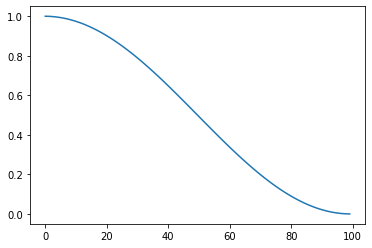

In [51]:
plt.plot(eco.water.res_counts)

In [12]:
eco.strategy_matrix[eco.strategy_matrix < 0]

array([], dtype=float64)

In [13]:
eco.parameters.layered_attack[eco.parameters.layered_attack == 0]

array([], dtype=float64)

In [29]:
eco.parameters.layered_attack - og_layered_attack

array([[[-2.17235808e-06, -3.59830910e-12, -2.94462697e-20,
         -1.19049306e-30, -2.19990253e-33],
        [-6.47931545e-03, -2.17235808e-06, -3.59830910e-12,
         -2.94462697e-20, -1.85917145e-22],
        [-9.54754252e-02, -6.47931545e-03, -2.17235808e-06,
         -3.59830910e-12, -7.76247495e-14],
        [-6.95054474e-03, -9.54754252e-02, -6.47931545e-03,
         -2.17235808e-06, -1.60120061e-07],
        [-1.77910025e-03, -8.34998636e-02, -1.93613608e-02,
         -2.21794490e-05, -2.17235808e-06]],

       [[-2.16591556e-06, -3.58763767e-12, -2.93589415e-20,
         -1.18696244e-30, -2.19337832e-33],
        [-6.46009988e-03, -2.16591556e-06, -3.58763767e-12,
         -2.93589415e-20, -1.85365775e-22],
        [-9.51922757e-02, -6.46009988e-03, -2.16591556e-06,
         -3.58763767e-12, -7.73945394e-14],
        [-6.92993165e-03, -9.51922757e-02, -6.46009988e-03,
         -2.16591556e-06, -1.59645196e-07],
        [-1.77382401e-03, -8.32522298e-02, -1.93039412e-02,
  

In [15]:
eco.parameters.who_eats_who[3,0] == 1

True

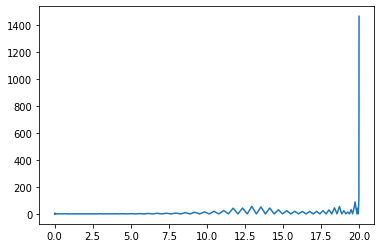

In [73]:
plt.plot(obj.x, x_res[layers:2*layers])

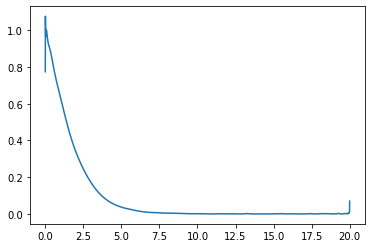

In [17]:
plt.plot(obj.x, x_res[3*layers:4*layers])

In [18]:
graph_builder(eco)

array([[ 0.00000000e+00, -3.17317494e-04, -6.54077692e-04,
        -6.87594565e-05,  7.19315987e-05],
       [ 0.00000000e+00,  0.00000000e+00,  3.45504743e-04,
        -2.14196578e-03,  4.17523758e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.76023224e-05,  8.98926204e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [19]:
eco.parameters.who_eats_who[3]*eco.populations

array([0.99999956, 0.99999774, 0.99997566, 0.        , 0.        ])

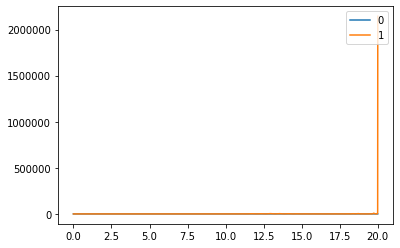

In [42]:
    plt.figure()
    for i in range(2):
        plt.plot(obj.x, x_res[i * layers:(i + 1) * layers]**2, label = i)
    plt.legend(loc = 'upper right')
    plt.show()


In [46]:
eco.parameters.layered_attack-og_layered_attack

array([[[-1.46977102e-07, -2.43453899e-13, -1.99227164e-21,
         -8.05462149e-32, -1.48840701e-34],
        [-4.38376628e-04, -1.46977102e-07, -2.43453899e-13,
         -1.99227164e-21, -1.25787565e-23],
        [-6.45966310e-03, -4.38376628e-04, -1.46977102e-07,
         -2.43453899e-13, -5.25192455e-15],
        [-4.70258993e-04, -6.45966310e-03, -4.38376628e-04,
         -1.46977102e-07, -1.08333809e-08],
        [-1.20370118e-04, -5.64942221e-03, -1.30994826e-03,
         -1.50061409e-06, -1.46977102e-07]],

       [[-1.46541215e-07, -2.42731892e-13, -1.98636320e-21,
         -8.03073406e-32, -1.48399287e-34],
        [-4.37076543e-04, -1.46541215e-07, -2.42731892e-13,
         -1.98636320e-21, -1.25414519e-23],
        [-6.44050581e-03, -4.37076543e-04, -1.46541215e-07,
         -2.42731892e-13, -5.23634903e-15],
        [-4.68864356e-04, -6.44050581e-03, -4.37076543e-04,
         -1.46541215e-07, -1.08012526e-08],
        [-1.20013139e-04, -5.63266783e-03, -1.30606338e-03,
  

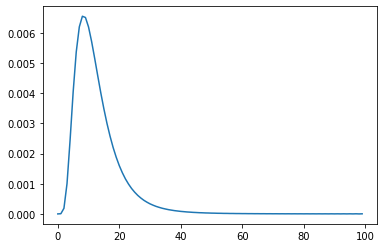

In [44]:
plt.plot(eco.water.res_counts)

In [21]:
print(graph_builder(eco))

[[ 0.00000000e+00 -3.17317494e-04 -6.54077692e-04 -6.87594565e-05
   7.19315987e-05]
 [ 0.00000000e+00  0.00000000e+00  3.45504743e-04 -2.14196578e-03
   4.17523758e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.76023224e-05
   8.98926204e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [22]:
eco.total_growth(eco.strategy_matrix.flatten())

array([-1.52540237e-05, -8.07955541e-03, -8.94668592e-02, -8.45702377e-01,
       -1.42207289e-01])

In [104]:
    A, one, bounds = constraint_builder(eco.spectral.M, eco.mass_vector.shape[0])
    constr1 = ({'type': 'eq', 'fun': lambda x: np.dot(A[0, 0:eco.layers], x**2) - 1})
    bounds1 = optm.Bounds(np.array([0] * eco.layers), np.array([np.inf] * eco.layers))
x_temp = np.copy(eco.strategy_matrix.flatten())

In [105]:
x0 = eco.water.res_counts/(np.dot(eco.ones, np.dot(eco.water.spectral.M, eco.water.res_counts)))

In [106]:
seq = sequential_nash(eco, verbose = verbose)

In [119]:
wats_up = optm.minimize(lambda x: -eco.one_actor_growth(eco.strategy_replacer(x, 0, x_temp), 0),
                x0=x0, method='SLSQP', constraints=constr1, bounds=bounds1)

In [120]:
wats_up

     fun: -0.2207919691637973
     jac: array([-2.99397856e-04, -1.34820491e-03, -2.39634886e-03, -3.49230878e-03,
       -4.44309600e-03, -5.24762273e-03, -5.97619079e-03, -6.55111484e-03,
       -6.92090951e-03, -7.10090250e-03, -7.06408732e-03, -6.75789826e-03,
       -6.18573464e-03, -5.42435236e-03, -4.55560721e-03, -3.66051123e-03,
       -2.80602649e-03, -2.07239762e-03, -1.46104954e-03, -9.29687172e-04,
       -4.54647467e-04, -1.40622258e-04,  5.14034182e-05,  1.44077465e-04,
        1.79974362e-04,  1.74546614e-04,  1.54729933e-04,  1.25123188e-04,
        9.88151878e-05,  7.36676157e-05,  5.51417470e-05,  3.93167138e-05,
        2.86325812e-05,  1.97757035e-05,  1.42827630e-05,  9.72859561e-06,
        6.45220280e-06,  3.86312604e-06,  2.51829624e-06,  1.42306089e-06,
        1.10454857e-06,  6.91041350e-07,  5.08502126e-07,  2.79396772e-07,
        2.47731805e-07,  1.39698386e-07,  1.04308128e-07,  4.09781933e-08,
        2.98023224e-08,  1.30385160e-08,  1.86264515e-08,  7

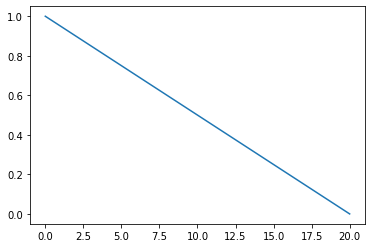

In [124]:
plt.plot(obj.x, eco.water.res_counts)

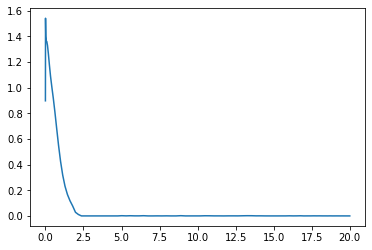

In [125]:
plt.plot(obj.x, wats_up.x)

In [ ]:
np.dot(eco.strategy_matrix.flatten()[eco.layers:2*eco.layers], np.dot(obj.M, x0))

In [ ]:
foraging_payoff_new = eco.parameters.layered_foraging[:,1]*new_dist*eco.water.res_counts*eco.parameters.clearance_rate[1]

foraging_payoff = eco.parameters.layered_foraging[:,1]*eco.strategy_matrix[1]*eco.water.res_counts*eco.parameters.clearance_rate[1]

In [ ]:
np.dot(eco.ones, np.dot(obj.M, foraging_payoff_new))/(1+np.dot(eco.ones, np.dot(obj.M, eco.parameters.handling_times[i]*foraging_payoff_new)))

In [ ]:
eco.one_actor_growth(eco.strategy_replacer(new_dist, 1, eco.strategy_matrix.flatten()), 1)

In [ ]:
eco.one_actor_growth(eco.strategy_matrix.flatten(), 1)

In [ ]:
plt.plot(obj.x, eco.strategy_matrix[4])